# Encoder-Decoder
Encoder: more complex ResNet50
Decoder: 3 LSTM layers (from https://www.kaggle.com/marbury/efficientnet-multi-layer-lstm-inference).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision.transforms import Resize

from tqdm import tqdm
import imageio
import gc

#from sklearn.model_selection import train_test_split

from ResNet import ResNetEncoderPretrained, ResNet50_modified

import Levenshtein

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [68]:
cfg = dict()
# some parameters
cfg['n_channels'] = 50
cfg['input_channels'] = 1
cfg['output_channels'] = 6
cfg['dropout'] = 0.2
#cfg['fc_intermediate_len'] = 100 # ? 128

# resizing images
cfg['x_size'] = 150 
cfg['y_size'] = 300 

# for decoder
cfg['attention_dim'] = 256
cfg['embedding_dim'] = 512
cfg['decoder_dim'] = 512
cfg['max_len'] = 275
cfg['num_lstm_layers'] = 2

# for training
cfg['train_dataset_file'] = 'data/decoder/train.csv'
cfg['valid_dataset_file'] = 'data/decoder/valid.csv'

In [69]:
class Tokenizer(object):
    
    def __init__(self):
        self.stoi = {}
        self.itos = {}

    def __len__(self):
        return len(self.stoi)
    
    def fit_on_texts(self, texts):
        vocab = set()
        for text in texts:
            vocab.update(text.split(' '))
        vocab = sorted(vocab)
        vocab.append('<sos>')
        vocab.append('<eos>')
        vocab.append('<pad>')
        for i, s in enumerate(vocab):
            self.stoi[s] = i
        self.itos = {item[1]: item[0] for item in self.stoi.items()}
        
    def text_to_sequence(self, text):
        sequence = []
        sequence.append(self.stoi['<sos>'])
        for s in text.split(' '):
            sequence.append(self.stoi[s])
        sequence.append(self.stoi['<eos>'])
        return sequence
    
    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            sequence = self.text_to_sequence(text)
            sequences.append(sequence)
        return sequences

    def sequence_to_text(self, sequence):
        return ''.join(list(map(lambda i: self.itos[i], sequence)))
    
    def sequences_to_texts(self, sequences):
        texts = []
        for sequence in sequences:
            text = self.sequence_to_text(sequence)
            texts.append(text)
        return texts
    
    def predict_caption(self, sequence):
        caption = ''
        for i in sequence:
            if i == self.stoi['<eos>'] or i == self.stoi['<pad>']:
                break
            caption += self.itos[i]
        return caption
    
    def predict_captions(self, sequences):
        captions = []
        for sequence in sequences:
            caption = self.predict_caption(sequence)
            captions.append(caption)
        return captions

tokenizer = torch.load('preprocessing_output/tokenizer2.pth')
print(f"tokenizer.stoi: {tokenizer.stoi}")

tokenizer.stoi: {'(': 0, ')': 1, '+': 2, ',': 3, '-': 4, '/b': 5, '/c': 6, '/h': 7, '/i': 8, '/m': 9, '/s': 10, '/t': 11, '0': 12, '1': 13, '10': 14, '100': 15, '101': 16, '102': 17, '103': 18, '104': 19, '105': 20, '106': 21, '107': 22, '108': 23, '109': 24, '11': 25, '110': 26, '111': 27, '112': 28, '113': 29, '114': 30, '115': 31, '116': 32, '117': 33, '118': 34, '119': 35, '12': 36, '120': 37, '121': 38, '122': 39, '123': 40, '124': 41, '125': 42, '126': 43, '127': 44, '128': 45, '129': 46, '13': 47, '130': 48, '131': 49, '132': 50, '133': 51, '134': 52, '135': 53, '136': 54, '137': 55, '138': 56, '139': 57, '14': 58, '140': 59, '141': 60, '142': 61, '143': 62, '144': 63, '145': 64, '146': 65, '147': 66, '148': 67, '149': 68, '15': 69, '150': 70, '151': 71, '152': 72, '153': 73, '154': 74, '155': 75, '156': 76, '157': 77, '158': 78, '159': 79, '16': 80, '161': 81, '163': 82, '165': 83, '167': 84, '17': 85, '18': 86, '19': 87, '2': 88, '20': 89, '21': 90, '22': 91, '23': 92, '24': 9

In [70]:
def load_pic(image_id, is_train=True):
    _ = 'train' if is_train else 'test'
    directory = 'original_data/{}/{}/{}/{}/'.format(_, image_id[0], image_id[1], image_id[2])
    return torch.Tensor(imageio.imread(directory + image_id + '.png') )

In [71]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, file, x_size=256, y_size=256, n_of_samples=None):
        data = pd.read_csv(file)
        self.n_of_samples = n_of_samples if n_of_samples else data.shape[0]
        self.data = data[:self.n_of_samples].drop(columns=['InChI_1', 'InChI_length'])
        
        self.x_size = x_size
        self.y_size = y_size
        self.resize = Resize(size=(x_size,y_size))
    
    def __len__(self):
        return self.n_of_samples
    
    def __getitem__(self, index):
        pic = load_pic(self.data['image_id'][index]).unsqueeze(0) # C=1 channel
        pic = self.resize(pic) / 255.
        label = self.data['InChI_text'][index]
        encoded_label = torch.LongTensor(tokenizer.text_to_sequence(label))
        return pic, encoded_label, encoded_label.shape[0]

In [72]:
# Is used to form batches in DataLoader of Dataset __getitem__
# Needed to create uniformly padded sequences for decoder
def CollateFunction(batch):
    images = []
    encoded_labels = []
    label_lengths = []
    for (image, encoded_label, label_length) in batch:
        images.append(image)
        encoded_labels.append(encoded_label)
        label_lengths.append(label_length)
    images = torch.stack(images)
    encoded_labels = nn.utils.rnn.pad_sequence(encoded_labels, batch_first=True,
                                               padding_value=tokenizer.stoi["<pad>"])
    #label_lengths = torch.stack(label_lengths).reshape(-1, 1)
    label_lengths = torch.LongTensor(label_lengths).reshape(-1, 1)
    return images, encoded_labels, label_lengths

In [82]:
####### RNN DECODER

# attention module
class Attention(nn.Module):
    '''
    Attention network for calculate attention value
    '''
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        '''
        :param encoder_dim: input size of encoder network
        :param decoder_dim: input size of decoder network
        :param attention_dim: input size of attention network
        '''
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # linear layer to transform encoded image
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # linear layer to transform decoder's output
        self.full_att    = nn.Linear(attention_dim, 1)            # linear layer to calculate values to be softmax-ed
        self.relu        = nn.ReLU()
        self.softmax     = nn.Softmax(dim = 1)  # softmax layer to calculate weights

    def forward(self, encoder_out, decoder_hidden):
        att1  = self.encoder_att(encoder_out)     # (batch_size, num_pixels, attention_dim)
        att2  = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att   = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)                 # (batch_size, num_pixels)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim = 1)  # (batch_size, encoder_dim)
        return attention_weighted_encoding, alpha
    
    
# custom LSTM cell
def LSTMCell(input_size, hidden_size, **kwargs):
    m = nn.LSTMCell(input_size, hidden_size, **kwargs)
    for name, param in m.named_parameters():
        if 'weight' in name or 'bias' in name:
            param.data.uniform_(-0.1, 0.1)
    return m


# decoder
class DecoderWithAttention(nn.Module):
    '''
    Decoder network with attention network used for training
    '''

    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, device, encoder_dim, dropout, num_layers):
        '''
        :param attention_dim: input size of attention network
        :param embed_dim: input size of embedding network
        :param decoder_dim: input size of decoder network
        :param vocab_size: total number of characters used in training
        :param encoder_dim: input size of encoder network
        :param num_layers: number of the LSTM layers
        :param dropout: dropout rate
        '''
        super(DecoderWithAttention, self).__init__()
        self.encoder_dim   = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim     = embed_dim
        self.decoder_dim   = decoder_dim
        self.vocab_size    = vocab_size
        self.dropout       = dropout
        self.num_layers    = num_layers
        self.device        = device
        self.attention     = Attention(encoder_dim, decoder_dim, attention_dim)  # attention network
        self.embedding     = nn.Embedding(vocab_size, embed_dim)                 # embedding layer
        self.dropout       = nn.Dropout(p = self.dropout)
        self.decode_step   = nn.ModuleList([LSTMCell(embed_dim + encoder_dim if layer == 0 else embed_dim, embed_dim) for layer in range(self.num_layers)]) # decoding LSTMCell        
        self.init_h        = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell
        self.init_c        = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell
        self.f_beta        = nn.Linear(decoder_dim, encoder_dim)  # linear layer to create a sigmoid-activated gate
        self.sigmoid       = nn.Sigmoid()
        self.fc            = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary
        self.init_weights()                                      # initialize some layers with the uniform distribution

    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def load_pretrained_embeddings(self, embeddings):
        self.embedding.weight = nn.Parameter(embeddings)

    def fine_tune_embeddings(self, fine_tune = True):
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim = 1)
        # debug
        #print('mean_encoder_out.shape', mean_encoder_out.shape)
        h = [self.init_h(mean_encoder_out) for i in range(self.num_layers)]  # (batch_size, decoder_dim)
        c = [self.init_c(mean_encoder_out) for i in range(self.num_layers)]
        # debug
        #print('h[0].shape', h[0].shape)
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        '''
        :param encoder_out: output of encoder network
        :param encoded_captions: transformed sequence from character to integer
        :param caption_lengths: length of transformed sequence
        '''
        batch_size       = encoder_out.size(0)
        encoder_dim      = encoder_out.size(-1)
        vocab_size       = self.vocab_size
        encoder_out      = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels       = encoder_out.size(1)
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim = 0, descending = True)
        encoder_out      = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]
        
        # embedding transformed sequence for vector
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)
        
        # Initialize LSTM state, initialize cell_vector and hidden_vector
        prev_h, prev_c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)
        
        # set decode length by caption length - 1 because of omitting start token
        decode_lengths = (caption_lengths - 1).tolist()
        predictions    = torch.zeros(batch_size, max(decode_lengths), vocab_size, device = self.device)
        alphas         = torch.zeros(batch_size, max(decode_lengths), num_pixels, device = self.device)
        
        # predict sequence
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                                prev_h[-1][:batch_size_t])
            gate = self.sigmoid(self.f_beta(prev_h[-1][:batch_size_t]))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding

            input = torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1)
            
            # debug
            #print('input.shape =', input.shape)
            #print('batch_size_t =', batch_size_t)
            #print('prev_h[0][:batch_size_t].shape =', prev_h[0][:batch_size_t].shape)
            
            for i, rnn in enumerate(self.decode_step):
                # recurrent cell
                h, c = rnn(input, (prev_h[i][:batch_size_t], prev_c[i][:batch_size_t])) # cell_vector and hidden_vector

                # hidden state becomes the input to the next layer
                input = self.dropout(h)

                # save state for next time step
                prev_h[i] = h
                prev_c[i] = c
                
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :]      = alpha
            
        return predictions, encoded_captions, decode_lengths, alphas, sort_ind
    
    def predict(self, encoder_out, decode_lengths, tokenizer):
        
        # size variables
        batch_size  = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size  = self.vocab_size
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels  = encoder_out.size(1)
        
        # embed start tocken for LSTM input
        start_tockens = torch.ones(batch_size, dtype = torch.long, device = self.device) * tokenizer.stoi['<sos>']
        embeddings    = self.embedding(start_tockens)
        
        # initialize hidden state and cell state of LSTM cell
        h, c        = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)
        predictions = torch.zeros(batch_size, decode_lengths, vocab_size, device = self.device)
        
        # predict sequence
        end_condition = torch.zeros(batch_size, dtype=torch.long, device = self.device)
        for t in range(decode_lengths):
            awe, alpha = self.attention(encoder_out, h[-1])  # (s, encoder_dim), (s, num_pixels)
            gate       = self.sigmoid(self.f_beta(h[-1]))    # gating scalar, (s, encoder_dim)
            awe        = gate * awe
            
            input = torch.cat([embeddings, awe], dim=1)
 
            for j, rnn in enumerate(self.decode_step):
                at_h, at_c = rnn(input, (h[j], c[j]))  # (s, decoder_dim)
                input = self.dropout(at_h)
                h[j]  = at_h
                c[j]  = at_c
            
            preds = self.fc(self.dropout(h[-1]))  # (batch_size_t, vocab_size)
            predictions[:, t, :] = preds
            end_condition |= (torch.argmax(preds, -1) == tokenizer.stoi["<eos>"])
            if end_condition.sum() == batch_size:
                break
            embeddings = self.embedding(torch.argmax(preds, -1))
        
        return predictions
    
    # beam search
    def forward_step(self, prev_tokens, hidden, encoder_out, function):
        
        h, c = hidden
        #h, c = h.squeeze(0), c.squeeze(0)
        h, c = [hi.squeeze(0) for hi in h], [ci.squeeze(0) for ci in c]
        
        embeddings = self.embedding(prev_tokens)
        if embeddings.dim() == 3:
            embeddings = embeddings.squeeze(1)
            
        awe, alpha = self.attention(encoder_out, h[-1])  # (s, encoder_dim), (s, num_pixels)
        gate       = self.sigmoid(self.f_beta(h[-1]))    # gating scalar, (s, encoder_dim)
        awe        = gate * awe
        
        input = torch.cat([embeddings, awe], dim = 1)
        for j, rnn in enumerate(self.decode_step):
            at_h, at_c = rnn(input, (h[j], c[j]))  # (s, decoder_dim)
            input = self.dropout(at_h)
            h[j]  = at_h
            c[j]  = at_c

        preds = self.fc(self.dropout(h[-1]))  # (batch_size_t, vocab_size)

        #hidden = (h.unsqueeze(0), c.unsqueeze(0))
        hidden = [hi.unsqueeze(0) for hi in h], [ci.unsqueeze(0) for ci in c]
        predicted_softmax = function(preds, dim = 1)
        
        return predicted_softmax, hidden, None

In [96]:
def eval_performance(encoder, decoder, data_loader, batch_size, max_count=float('+inf')):
    
    encoder.eval()
    decoder.eval()
    count = 0
    loss  = 0.
    edit_dist = 0
    
    for (images, labels, label_lengths) in data_loader:
        batch_size = images.shape[0]
        
        # make predictions (run forward)
        images = images.to(device)
        with torch.no_grad():
            features = encoder(images)
            # FIXME FOR STANDARD KAGGLE MODEL
            features = features.reshape(images.shape[0], 1, 1, 512)
            predictions = decoder.predict(features, cfg['max_len'], tokenizer)
        
        # transform predictions to text
        predicted_sequences = torch.argmax(predictions.detach().cpu(), -1).numpy()
        #     predictions: batch_size x cfg['max_len'] x len(tokenizer)
        #     predicted_sequences = batch_size x cfg['max_len']
        text_predictions = tokenizer.predict_captions(predicted_sequences)
        #print('Text predictions:')
        #print(text_predictions)
        text_targets = tokenizer.predict_captions(labels.detach().cpu().numpy())
        if count == 0:
            print(text_predictions[0])
        # calc metrics
        for i in range(batch_size):
            edit_dist += Levenshtein.distance(text_predictions[i], text_targets[i])
        #loss += loss_function(predictions, labels)

        count += batch_size
        if count > max_count:
            break
    loss = loss / count
    edit_dist = edit_dist / count
    return loss, edit_dist

In [97]:
def train_epoch(data_loader, encoder, decoder, optimizer, criterion):
    encoder.train()
    decoder.train()
    for (images, labels, label_lengths) in tqdm(data_loader): # labels already encoded
        
        # 1. Move batch to GPU (if available)
        images = images.to(device)
        labels = labels.to(device)
        label_lengths = label_lengths.to(device)
        
        # 2. Zeroing gradients.
        optimizer.zero_grad()
        
        # 3. Forward pass
        features = encoder(images)
        features = features.reshape(images.shape[0], 1, 1, 512)
        
        predictions, caps_sorted, decode_lengths, alphas, sort_ind = decoder(features, labels, label_lengths)
        targets = caps_sorted[:, 1:]
        predictions = nn.utils.rnn.pack_padded_sequence(predictions, decode_lengths, batch_first=True).data
        targets = nn.utils.rnn.pack_padded_sequence(targets, decode_lengths, batch_first=True).data
        
        # 4. Calculate loss.
        loss = criterion(predictions, targets)
        print('batch_loss', loss.item()) # debug
        
        # 5. Calculate gradients and perform optimization step.
        loss.backward() # clip_grad_norm may be used after this
        optimizer.step()

In [102]:
def train_model(encoder, decoder, n_epochs, batch_size, history, finetune_encoder=False):
    
    # 1. Initialize and prepare data
    dataset_train = TrainDataset(file=cfg['train_dataset_file'], 
                                 x_size=cfg['x_size'], y_size=cfg['y_size'], n_of_samples=1000)
    
    #dataset_valid = TrainDataset(file=cfg['valid_dataset_file'],
    #                             x_size=cfg['x_size'], y_size=cfg['y_size'], n_of_samples=100)
    
    data_train_loader = torch.utils.data.DataLoader(dataset_train, batch_size,
                                                   num_workers=6, persistent_workers=True, pin_memory=True,
                                                   collate_fn=CollateFunction)
    #data_valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size,
    #                                                num_workers=2, persistent_workers=False, pin_memory=False,
    #                                              collate_fn=CollateFunction)
    
    # 2. Initialize loss and optimizer parameters
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.stoi["<pad>"]) # like in the link
    
    params_to_optimize = list(decoder.parameters())
    if finetune_encoder:
        params_to_optimize.extend(encoder.parameters())
    
    optimizer = torch.optim.Adam(params_to_optimize, lr=0.00005)
    
    # 3. Move model to GPU (if available)
    encoder.to(device)
    decoder.to(device)
    
    # 4. Train for n_epochs, calculating loss/metrics and saving model parameters
    for i in range(n_epochs):
        print('Starting epoch {}'.format(i))
        
        train_epoch(data_train_loader, encoder, decoder, optimizer, criterion)
        
        # save model
        torch.save(decoder.state_dict(), 'data/decoder/decoder_v1_epoch_{}.model'.format(i))
        if finetune_encoder:
            torch.save(encoder.state_dict(), 'data/decoder/encoder_v1_epoch_{}.model'.format(i))
        
        # print and save metrics
        train_loss, train_metric = eval_performance(encoder, decoder, data_train_loader,
                                                    batch_size, max_count=15)
        valid_loss, valid_metric = 0.1, 0.1 #eval_performance(encoder, decoder, data_valid_loader, batch_size)
        print('Train loss:\t{:f}, \t test loss:\t{:f}'.format(train_loss, valid_loss))
        print('Levenshtein distance: on train:\t{},\t on test:\t{}'.format(train_metric, valid_metric))
        history[i,0] = train_loss
        history[i,1] = valid_loss
        history[i,2] = train_metric
        history[i,3] = valid_metric

In [105]:
N_EPOCHS = 4
history = np.zeros((N_EPOCHS, 4))

In [106]:
encoder = ResNet50_modified().to(device)
decoder = DecoderWithAttention(cfg['attention_dim'], embed_dim=cfg['embedding_dim'], 
                               decoder_dim=cfg['decoder_dim'], 
                               vocab_size=len(tokenizer), dropout=cfg['dropout'],
                               device=device, encoder_dim=512, num_layers=2).to(device) #cfg['num_lstm_layers']
# attention_dim, embed_dim, decoder_dim, vocab_size, device, encoder_dim, dropout, num_layers

In [107]:
%%time
train_model(encoder, decoder, N_EPOCHS, batch_size=10, history=history, finetune_encoder=True)

  0%|          | 0/100 [00:00<?, ?it/s]

Starting epoch 0
batch_loss 5.227646350860596


  1%|          | 1/100 [00:00<01:12,  1.36it/s]

batch_loss 5.139660835266113


  2%|▏         | 2/100 [00:01<01:04,  1.51it/s]

batch_loss 5.0415358543396


  3%|▎         | 3/100 [00:01<00:59,  1.62it/s]

batch_loss 4.968874454498291


  4%|▍         | 4/100 [00:02<00:56,  1.70it/s]

batch_loss 4.885272026062012


  5%|▌         | 5/100 [00:02<00:56,  1.69it/s]

batch_loss 4.818418025970459


  6%|▌         | 6/100 [00:03<00:51,  1.81it/s]

batch_loss 4.734644889831543


  7%|▋         | 7/100 [00:03<00:49,  1.87it/s]

batch_loss 4.6746320724487305


  8%|▊         | 8/100 [00:04<00:50,  1.84it/s]

batch_loss 4.635593891143799


  9%|▉         | 9/100 [00:04<00:50,  1.79it/s]

batch_loss 4.55331563949585


 10%|█         | 10/100 [00:05<00:48,  1.84it/s]

batch_loss 4.478105068206787


 11%|█         | 11/100 [00:06<00:47,  1.86it/s]

batch_loss 4.4105119705200195


 12%|█▏        | 12/100 [00:06<00:48,  1.80it/s]

batch_loss 4.391432285308838


 13%|█▎        | 13/100 [00:07<00:46,  1.87it/s]

batch_loss 4.374366283416748


 14%|█▍        | 14/100 [00:07<00:44,  1.92it/s]

batch_loss 4.338007926940918


 15%|█▌        | 15/100 [00:08<00:44,  1.93it/s]

batch_loss 4.22848653793335


 16%|█▌        | 16/100 [00:08<00:45,  1.84it/s]

batch_loss 4.219288349151611


 17%|█▋        | 17/100 [00:09<00:44,  1.86it/s]

batch_loss 4.24336576461792


 18%|█▊        | 18/100 [00:09<00:43,  1.88it/s]

batch_loss 4.162312984466553


 19%|█▉        | 19/100 [00:10<00:42,  1.91it/s]

batch_loss 4.113111972808838


 20%|██        | 20/100 [00:10<00:40,  1.96it/s]

batch_loss 4.15606164932251


 21%|██        | 21/100 [00:11<00:40,  1.96it/s]

batch_loss 4.0730671882629395


 22%|██▏       | 22/100 [00:11<00:42,  1.85it/s]

batch_loss 4.05510139465332


 23%|██▎       | 23/100 [00:12<00:40,  1.90it/s]

batch_loss 4.044593811035156


 24%|██▍       | 24/100 [00:12<00:40,  1.87it/s]

batch_loss 4.037618160247803


 25%|██▌       | 25/100 [00:13<00:39,  1.90it/s]

batch_loss 3.9002437591552734


 26%|██▌       | 26/100 [00:13<00:38,  1.94it/s]

batch_loss 3.961599826812744


 27%|██▋       | 27/100 [00:14<00:36,  1.98it/s]

batch_loss 3.91977596282959


 28%|██▊       | 28/100 [00:14<00:36,  1.98it/s]

batch_loss 3.9152166843414307


 29%|██▉       | 29/100 [00:15<00:36,  1.93it/s]

batch_loss 3.8503763675689697


 30%|███       | 30/100 [00:15<00:37,  1.88it/s]

batch_loss 3.804161310195923


 31%|███       | 31/100 [00:16<00:34,  1.98it/s]

batch_loss 3.7820327281951904


 32%|███▏      | 32/100 [00:16<00:33,  2.05it/s]

batch_loss 3.860044002532959


 33%|███▎      | 33/100 [00:17<00:35,  1.91it/s]

batch_loss 3.7798349857330322


 34%|███▍      | 34/100 [00:18<00:34,  1.90it/s]

batch_loss 3.7989087104797363


 35%|███▌      | 35/100 [00:18<00:34,  1.90it/s]

batch_loss 3.8179967403411865


 36%|███▌      | 36/100 [00:19<00:34,  1.86it/s]

batch_loss 3.7297964096069336


 37%|███▋      | 37/100 [00:19<00:33,  1.89it/s]

batch_loss 3.6642906665802


 38%|███▊      | 38/100 [00:20<00:32,  1.93it/s]

batch_loss 3.74497127532959


 39%|███▉      | 39/100 [00:20<00:33,  1.84it/s]

batch_loss 3.640533924102783


 40%|████      | 40/100 [00:21<00:31,  1.91it/s]

batch_loss 3.607309103012085


 41%|████      | 41/100 [00:21<00:29,  1.98it/s]

batch_loss 3.6604163646698


 42%|████▏     | 42/100 [00:22<00:30,  1.91it/s]

batch_loss 3.664259672164917


 43%|████▎     | 43/100 [00:22<00:30,  1.87it/s]

batch_loss 3.5666866302490234


 44%|████▍     | 44/100 [00:23<00:28,  1.95it/s]

batch_loss 3.667414903640747


 45%|████▌     | 45/100 [00:23<00:30,  1.81it/s]

batch_loss 3.6102535724639893


 46%|████▌     | 46/100 [00:24<00:30,  1.80it/s]

batch_loss 3.646406888961792


 47%|████▋     | 47/100 [00:24<00:29,  1.82it/s]

batch_loss 3.518310546875


 48%|████▊     | 48/100 [00:25<00:26,  1.93it/s]

batch_loss 3.5240256786346436


 49%|████▉     | 49/100 [00:25<00:25,  2.00it/s]

batch_loss 3.5343992710113525


 50%|█████     | 50/100 [00:26<00:25,  1.94it/s]

batch_loss 3.4669604301452637


 51%|█████     | 51/100 [00:26<00:25,  1.93it/s]

batch_loss 3.498828649520874


 52%|█████▏    | 52/100 [00:27<00:24,  1.93it/s]

batch_loss 3.4960198402404785


 53%|█████▎    | 53/100 [00:27<00:23,  1.97it/s]

batch_loss 3.479302167892456


 54%|█████▍    | 54/100 [00:28<00:22,  2.01it/s]

batch_loss 3.447901725769043


 55%|█████▌    | 55/100 [00:28<00:22,  2.00it/s]

batch_loss 3.5660459995269775


 56%|█████▌    | 56/100 [00:29<00:22,  1.99it/s]

batch_loss 3.463623046875


 57%|█████▋    | 57/100 [00:29<00:22,  1.94it/s]

batch_loss 3.5097873210906982


 58%|█████▊    | 58/100 [00:30<00:22,  1.85it/s]

batch_loss 3.4104387760162354


 59%|█████▉    | 59/100 [00:31<00:21,  1.88it/s]

batch_loss 3.401945114135742


 60%|██████    | 60/100 [00:31<00:20,  1.92it/s]

batch_loss 3.4486749172210693


 61%|██████    | 61/100 [00:32<00:20,  1.91it/s]

batch_loss 3.476806163787842


 62%|██████▏   | 62/100 [00:32<00:19,  1.93it/s]

batch_loss 3.4098124504089355


 63%|██████▎   | 63/100 [00:33<00:19,  1.90it/s]

batch_loss 3.3080191612243652


 64%|██████▍   | 64/100 [00:33<00:18,  1.95it/s]

batch_loss 3.4555795192718506


 65%|██████▌   | 65/100 [00:34<00:18,  1.89it/s]

batch_loss 3.334216833114624


 66%|██████▌   | 66/100 [00:34<00:17,  1.93it/s]

batch_loss 3.4344725608825684


 67%|██████▋   | 67/100 [00:35<00:16,  1.94it/s]

batch_loss 3.412438154220581


 68%|██████▊   | 68/100 [00:35<00:16,  1.95it/s]

batch_loss 3.3514885902404785


 69%|██████▉   | 69/100 [00:36<00:16,  1.87it/s]

batch_loss 3.275681257247925


 70%|███████   | 70/100 [00:36<00:15,  1.93it/s]

batch_loss 3.3194005489349365


 71%|███████   | 71/100 [00:37<00:15,  1.93it/s]

batch_loss 3.28481388092041


 72%|███████▏  | 72/100 [00:37<00:14,  1.94it/s]

batch_loss 3.3503332138061523


 73%|███████▎  | 73/100 [00:38<00:13,  1.96it/s]

batch_loss 3.2586629390716553


 74%|███████▍  | 74/100 [00:38<00:12,  2.00it/s]

batch_loss 3.2906973361968994


 75%|███████▌  | 75/100 [00:39<00:13,  1.90it/s]

batch_loss 3.3335556983947754


 76%|███████▌  | 76/100 [00:39<00:12,  1.89it/s]

batch_loss 3.279202938079834


 77%|███████▋  | 77/100 [00:40<00:11,  1.93it/s]

batch_loss 3.2895023822784424


 78%|███████▊  | 78/100 [00:40<00:11,  1.95it/s]

batch_loss 3.179978847503662


 79%|███████▉  | 79/100 [00:41<00:10,  1.98it/s]

batch_loss 3.3358705043792725


 80%|████████  | 80/100 [00:41<00:10,  1.88it/s]

batch_loss 3.2755935192108154


 81%|████████  | 81/100 [00:42<00:10,  1.88it/s]

batch_loss 3.2755091190338135


 82%|████████▏ | 82/100 [00:43<00:09,  1.87it/s]

batch_loss 3.171454906463623


 83%|████████▎ | 83/100 [00:43<00:08,  1.94it/s]

batch_loss 3.261038064956665


 84%|████████▍ | 84/100 [00:44<00:08,  1.92it/s]

batch_loss 3.2454674243927


 85%|████████▌ | 85/100 [00:44<00:07,  1.94it/s]

batch_loss 3.2667369842529297


 86%|████████▌ | 86/100 [00:45<00:07,  1.93it/s]

batch_loss 3.2748382091522217


 87%|████████▋ | 87/100 [00:45<00:06,  1.93it/s]

batch_loss 3.257520914077759


 88%|████████▊ | 88/100 [00:46<00:06,  1.94it/s]

batch_loss 3.257906675338745


 89%|████████▉ | 89/100 [00:46<00:06,  1.82it/s]

batch_loss 3.294964551925659


 90%|█████████ | 90/100 [00:47<00:05,  1.80it/s]

batch_loss 3.3481485843658447


 91%|█████████ | 91/100 [00:47<00:04,  1.83it/s]

batch_loss 3.2076621055603027


 92%|█████████▏| 92/100 [00:48<00:04,  1.86it/s]

batch_loss 3.251549482345581


 93%|█████████▎| 93/100 [00:48<00:03,  1.84it/s]

batch_loss 3.18986439704895


 94%|█████████▍| 94/100 [00:49<00:03,  1.89it/s]

batch_loss 3.278076410293579


 95%|█████████▌| 95/100 [00:49<00:02,  1.90it/s]

batch_loss 3.2271904945373535


 96%|█████████▌| 96/100 [00:50<00:02,  1.88it/s]

batch_loss 3.2584145069122314


 97%|█████████▋| 97/100 [00:50<00:01,  1.90it/s]

batch_loss 3.0866127014160156


 98%|█████████▊| 98/100 [00:51<00:01,  1.96it/s]

batch_loss 3.266482353210449


 99%|█████████▉| 99/100 [00:51<00:00,  1.94it/s]

batch_loss 3.2973690032958984


100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


CHHHNNO/c----------------------------------------------------------------------------,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


  0%|          | 0/100 [00:00<?, ?it/s]

Train loss:	0.000000, 	 test loss:	0.100000
Levenshtein distance: on train:	256.65,	 on test:	0.1
Starting epoch 1
batch_loss 3.203678607940674


  1%|          | 1/100 [00:00<00:54,  1.82it/s]

batch_loss 3.100160598754883


  2%|▏         | 2/100 [00:01<00:52,  1.88it/s]

batch_loss 3.154766321182251


  3%|▎         | 3/100 [00:01<00:50,  1.90it/s]

batch_loss 3.2208070755004883


  4%|▍         | 4/100 [00:02<00:50,  1.91it/s]

batch_loss 3.315382480621338


  5%|▌         | 5/100 [00:02<00:51,  1.84it/s]

batch_loss 3.1269543170928955


  6%|▌         | 6/100 [00:03<00:48,  1.92it/s]

batch_loss 3.163093328475952


  7%|▋         | 7/100 [00:03<00:47,  1.96it/s]

batch_loss 3.1980764865875244


  8%|▊         | 8/100 [00:04<00:48,  1.90it/s]

batch_loss 3.3066747188568115


  9%|▉         | 9/100 [00:04<00:49,  1.84it/s]

batch_loss 3.1348683834075928


 10%|█         | 10/100 [00:05<00:48,  1.87it/s]

batch_loss 3.1881062984466553


 11%|█         | 11/100 [00:05<00:47,  1.89it/s]

batch_loss 3.254546880722046


 12%|█▏        | 12/100 [00:06<00:48,  1.82it/s]

batch_loss 3.105915069580078


 13%|█▎        | 13/100 [00:06<00:45,  1.90it/s]

batch_loss 3.1760847568511963


 14%|█▍        | 14/100 [00:07<00:44,  1.95it/s]

batch_loss 3.1366758346557617


 15%|█▌        | 15/100 [00:07<00:43,  1.94it/s]

batch_loss 3.277069568634033


 16%|█▌        | 16/100 [00:08<00:45,  1.85it/s]

batch_loss 3.174725294113159


 17%|█▋        | 17/100 [00:08<00:44,  1.87it/s]

batch_loss 3.2358832359313965


 18%|█▊        | 18/100 [00:09<00:43,  1.89it/s]

batch_loss 3.1228790283203125


 19%|█▉        | 19/100 [00:10<00:42,  1.92it/s]

batch_loss 3.0771749019622803


 20%|██        | 20/100 [00:10<00:40,  1.97it/s]

batch_loss 3.148806095123291


 21%|██        | 21/100 [00:10<00:40,  1.97it/s]

batch_loss 3.1806490421295166


 22%|██▏       | 22/100 [00:11<00:41,  1.87it/s]

batch_loss 3.200808525085449


 23%|██▎       | 23/100 [00:12<00:40,  1.91it/s]

batch_loss 3.143040180206299


 24%|██▍       | 24/100 [00:12<00:40,  1.88it/s]

batch_loss 3.160102605819702


 25%|██▌       | 25/100 [00:13<00:39,  1.91it/s]

batch_loss 3.080641984939575


 26%|██▌       | 26/100 [00:13<00:38,  1.95it/s]

batch_loss 3.173316717147827


 27%|██▋       | 27/100 [00:14<00:36,  1.98it/s]

batch_loss 3.0756866931915283


 28%|██▊       | 28/100 [00:14<00:36,  1.98it/s]

batch_loss 3.184422492980957


 29%|██▉       | 29/100 [00:15<00:36,  1.93it/s]

batch_loss 3.1354353427886963


 30%|███       | 30/100 [00:15<00:36,  1.89it/s]

batch_loss 3.0409529209136963


 31%|███       | 31/100 [00:16<00:34,  1.99it/s]

batch_loss 3.025634527206421


 32%|███▏      | 32/100 [00:16<00:33,  2.06it/s]

batch_loss 3.300119400024414


 33%|███▎      | 33/100 [00:17<00:34,  1.92it/s]

batch_loss 3.1229569911956787


 34%|███▍      | 34/100 [00:17<00:34,  1.90it/s]

batch_loss 3.1220738887786865


 35%|███▌      | 35/100 [00:18<00:33,  1.91it/s]

batch_loss 3.249688148498535


 36%|███▌      | 36/100 [00:18<00:34,  1.86it/s]

batch_loss 3.098724842071533


 37%|███▋      | 37/100 [00:19<00:33,  1.89it/s]

batch_loss 3.0806150436401367


 38%|███▊      | 38/100 [00:19<00:31,  1.95it/s]

batch_loss 3.227045774459839


 39%|███▉      | 39/100 [00:20<00:32,  1.85it/s]

batch_loss 3.0552291870117188


 40%|████      | 40/100 [00:20<00:31,  1.92it/s]

batch_loss 3.0369174480438232


 41%|████      | 41/100 [00:21<00:29,  1.98it/s]

batch_loss 3.1582107543945312


 42%|████▏     | 42/100 [00:21<00:29,  1.93it/s]

batch_loss 3.182115077972412


 43%|████▎     | 43/100 [00:22<00:30,  1.89it/s]

batch_loss 3.0410501956939697


 44%|████▍     | 44/100 [00:22<00:28,  1.95it/s]

batch_loss 3.2885053157806396


 45%|████▌     | 45/100 [00:23<00:30,  1.82it/s]

batch_loss 3.157470941543579


 46%|████▌     | 46/100 [00:24<00:30,  1.80it/s]

batch_loss 3.2325439453125


 47%|████▋     | 47/100 [00:24<00:29,  1.81it/s]

batch_loss 3.0423614978790283


 48%|████▊     | 48/100 [00:25<00:26,  1.93it/s]

batch_loss 3.076929807662964


 49%|████▉     | 49/100 [00:25<00:25,  1.99it/s]

batch_loss 3.121619701385498


 50%|█████     | 50/100 [00:26<00:25,  1.93it/s]

batch_loss 3.0295369625091553


 51%|█████     | 51/100 [00:26<00:25,  1.92it/s]

batch_loss 3.1002707481384277


 52%|█████▏    | 52/100 [00:27<00:24,  1.93it/s]

batch_loss 3.0632646083831787


 53%|█████▎    | 53/100 [00:27<00:23,  1.97it/s]

batch_loss 3.0665194988250732


 54%|█████▍    | 54/100 [00:28<00:22,  2.02it/s]

batch_loss 3.034860134124756


 55%|█████▌    | 55/100 [00:28<00:22,  2.02it/s]

batch_loss 3.211679697036743


 56%|█████▌    | 56/100 [00:29<00:21,  2.00it/s]

batch_loss 3.1207172870635986


 57%|█████▋    | 57/100 [00:29<00:22,  1.95it/s]

batch_loss 3.137563943862915


 58%|█████▊    | 58/100 [00:30<00:22,  1.86it/s]

batch_loss 3.053565263748169


 59%|█████▉    | 59/100 [00:30<00:21,  1.89it/s]

batch_loss 3.0718271732330322


 60%|██████    | 60/100 [00:31<00:20,  1.93it/s]

batch_loss 3.098517894744873


 61%|██████    | 61/100 [00:31<00:20,  1.92it/s]

batch_loss 3.140127420425415


 62%|██████▏   | 62/100 [00:32<00:19,  1.94it/s]

batch_loss 3.1069376468658447


 63%|██████▎   | 63/100 [00:32<00:19,  1.90it/s]

batch_loss 2.970846176147461


 64%|██████▍   | 64/100 [00:33<00:18,  1.95it/s]

batch_loss 3.2014570236206055


 65%|██████▌   | 65/100 [00:33<00:18,  1.89it/s]

batch_loss 3.014874219894409


 66%|██████▌   | 66/100 [00:34<00:17,  1.94it/s]

batch_loss 3.128371477127075


 67%|██████▋   | 67/100 [00:34<00:16,  1.95it/s]

batch_loss 3.1161768436431885


 68%|██████▊   | 68/100 [00:35<00:16,  1.96it/s]

batch_loss 3.154273748397827


 69%|██████▉   | 69/100 [00:35<00:16,  1.87it/s]

batch_loss 2.974165439605713


 70%|███████   | 70/100 [00:36<00:15,  1.93it/s]

batch_loss 3.043148994445801


 71%|███████   | 71/100 [00:36<00:14,  1.93it/s]

batch_loss 3.007524251937866


 72%|███████▏  | 72/100 [00:37<00:14,  1.95it/s]

batch_loss 3.066026449203491


 73%|███████▎  | 73/100 [00:38<00:13,  1.96it/s]

batch_loss 2.9877946376800537


 74%|███████▍  | 74/100 [00:38<00:12,  2.00it/s]

batch_loss 3.0574264526367188


 75%|███████▌  | 75/100 [00:38<00:12,  1.98it/s]

batch_loss 3.0794265270233154


 76%|███████▌  | 76/100 [00:39<00:12,  1.99it/s]

batch_loss 3.0266542434692383


 77%|███████▋  | 77/100 [00:39<00:11,  2.00it/s]

batch_loss 3.1405582427978516


 78%|███████▊  | 78/100 [00:40<00:10,  2.00it/s]

batch_loss 2.9710443019866943


 79%|███████▉  | 79/100 [00:40<00:10,  2.02it/s]

batch_loss 3.114258289337158


 80%|████████  | 80/100 [00:41<00:10,  1.90it/s]

batch_loss 3.106624126434326


 81%|████████  | 81/100 [00:42<00:10,  1.90it/s]

batch_loss 3.057131052017212


 82%|████████▏ | 82/100 [00:42<00:09,  1.89it/s]

batch_loss 2.9276111125946045


 83%|████████▎ | 83/100 [00:43<00:08,  1.97it/s]

batch_loss 3.022874593734741


 84%|████████▍ | 84/100 [00:43<00:08,  1.94it/s]

batch_loss 2.980750322341919


 85%|████████▌ | 85/100 [00:44<00:07,  1.96it/s]

batch_loss 3.053098678588867


 86%|████████▌ | 86/100 [00:44<00:07,  1.95it/s]

batch_loss 3.1134917736053467


 87%|████████▋ | 87/100 [00:45<00:06,  1.95it/s]

batch_loss 3.0337774753570557


 88%|████████▊ | 88/100 [00:45<00:06,  1.96it/s]

batch_loss 3.1113617420196533


 89%|████████▉ | 89/100 [00:46<00:05,  1.84it/s]

batch_loss 3.1066977977752686


 90%|█████████ | 90/100 [00:46<00:05,  1.82it/s]

batch_loss 3.148238182067871


 91%|█████████ | 91/100 [00:47<00:04,  1.85it/s]

batch_loss 3.003770589828491


 92%|█████████▏| 92/100 [00:47<00:04,  1.87it/s]

batch_loss 3.0434420108795166


 93%|█████████▎| 93/100 [00:48<00:03,  1.84it/s]

batch_loss 3.0248982906341553


 94%|█████████▍| 94/100 [00:48<00:03,  1.85it/s]

batch_loss 3.0785539150238037


 95%|█████████▌| 95/100 [00:49<00:02,  1.84it/s]

batch_loss 3.0696473121643066


 96%|█████████▌| 96/100 [00:50<00:02,  1.81it/s]

batch_loss 3.1137993335723877


 97%|█████████▋| 97/100 [00:50<00:01,  1.82it/s]

batch_loss 2.899841785430908


 98%|█████████▊| 98/100 [00:51<00:01,  1.85it/s]

batch_loss 3.0942142009735107


 99%|█████████▉| 99/100 [00:51<00:00,  1.86it/s]

batch_loss 3.1381380558013916


100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


CHHHNNOO/c/c-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

Train loss:	0.000000, 	 test loss:	0.100000
Levenshtein distance: on train:	260.25,	 on test:	0.1
Starting epoch 2
batch_loss 3.0521926879882812


  1%|          | 1/100 [00:00<00:53,  1.84it/s]

batch_loss 2.9105031490325928


  2%|▏         | 2/100 [00:01<00:51,  1.89it/s]

batch_loss 2.97097110748291


  3%|▎         | 3/100 [00:01<00:50,  1.90it/s]

batch_loss 3.0417704582214355


  4%|▍         | 4/100 [00:02<00:50,  1.91it/s]

batch_loss 3.1897146701812744


  5%|▌         | 5/100 [00:02<00:52,  1.82it/s]

batch_loss 2.970639944076538


  6%|▌         | 6/100 [00:03<00:49,  1.90it/s]

batch_loss 2.986515522003174


  7%|▋         | 7/100 [00:03<00:48,  1.93it/s]

batch_loss 3.0113401412963867


  8%|▊         | 8/100 [00:04<00:49,  1.88it/s]

batch_loss 3.165964126586914


  9%|▉         | 9/100 [00:04<00:50,  1.82it/s]

batch_loss 2.9755492210388184


 10%|█         | 10/100 [00:05<00:50,  1.80it/s]

batch_loss 3.0424702167510986


 11%|█         | 11/100 [00:05<00:48,  1.83it/s]

batch_loss 3.0959510803222656


 12%|█▏        | 12/100 [00:06<00:49,  1.78it/s]

batch_loss 2.96114182472229


 13%|█▎        | 13/100 [00:06<00:46,  1.86it/s]

batch_loss 3.0066781044006348


 14%|█▍        | 14/100 [00:07<00:44,  1.91it/s]

batch_loss 2.9549624919891357


 15%|█▌        | 15/100 [00:07<00:44,  1.92it/s]

batch_loss 3.1335980892181396


 16%|█▌        | 16/100 [00:08<00:45,  1.83it/s]

batch_loss 3.064936876296997


 17%|█▋        | 17/100 [00:09<00:45,  1.83it/s]

batch_loss 3.0937883853912354


 18%|█▊        | 18/100 [00:09<00:44,  1.83it/s]

batch_loss 2.9675400257110596


 19%|█▉        | 19/100 [00:10<00:44,  1.84it/s]

batch_loss 2.9218966960906982


 20%|██        | 20/100 [00:10<00:42,  1.88it/s]

batch_loss 2.979944944381714


 21%|██        | 21/100 [00:11<00:42,  1.88it/s]

batch_loss 3.0286591053009033


 22%|██▏       | 22/100 [00:11<00:43,  1.78it/s]

batch_loss 3.0344483852386475


 23%|██▎       | 23/100 [00:12<00:42,  1.82it/s]

batch_loss 2.964271306991577


 24%|██▍       | 24/100 [00:12<00:42,  1.80it/s]

batch_loss 2.991826057434082


 25%|██▌       | 25/100 [00:13<00:41,  1.83it/s]

batch_loss 2.9714982509613037


 26%|██▌       | 26/100 [00:14<00:39,  1.87it/s]

batch_loss 3.000823497772217


 27%|██▋       | 27/100 [00:14<00:38,  1.89it/s]

batch_loss 2.9277408123016357


 28%|██▊       | 28/100 [00:15<00:37,  1.91it/s]

batch_loss 3.0727906227111816


 29%|██▉       | 29/100 [00:15<00:38,  1.86it/s]

batch_loss 3.0327184200286865


 30%|███       | 30/100 [00:16<00:38,  1.83it/s]

batch_loss 2.892700433731079


 31%|███       | 31/100 [00:16<00:35,  1.94it/s]

batch_loss 2.885313034057617


 32%|███▏      | 32/100 [00:17<00:33,  2.01it/s]

batch_loss 3.171877861022949


 33%|███▎      | 33/100 [00:17<00:36,  1.84it/s]

batch_loss 2.982114553451538


 34%|███▍      | 34/100 [00:18<00:36,  1.80it/s]

batch_loss 2.9766619205474854


 35%|███▌      | 35/100 [00:18<00:35,  1.83it/s]

batch_loss 3.0941989421844482


 36%|███▌      | 36/100 [00:19<00:36,  1.73it/s]

batch_loss 2.971830129623413


 37%|███▋      | 37/100 [00:20<00:35,  1.79it/s]

batch_loss 2.9107041358947754


 38%|███▊      | 38/100 [00:20<00:33,  1.85it/s]

batch_loss 3.106663227081299


 39%|███▉      | 39/100 [00:21<00:34,  1.76it/s]

batch_loss 2.9241232872009277


 40%|████      | 40/100 [00:21<00:32,  1.83it/s]

batch_loss 2.938483953475952


 41%|████      | 41/100 [00:22<00:31,  1.88it/s]

batch_loss 3.0629615783691406


 42%|████▏     | 42/100 [00:22<00:31,  1.83it/s]

batch_loss 3.01149845123291


 43%|████▎     | 43/100 [00:23<00:31,  1.79it/s]

batch_loss 2.8787600994110107


 44%|████▍     | 44/100 [00:23<00:29,  1.87it/s]

batch_loss 3.136035680770874


 45%|████▌     | 45/100 [00:24<00:31,  1.76it/s]

batch_loss 3.059680461883545


 46%|████▌     | 46/100 [00:24<00:30,  1.75it/s]

batch_loss 3.0925452709198


 47%|████▋     | 47/100 [00:25<00:29,  1.78it/s]

batch_loss 2.8822014331817627


 48%|████▊     | 48/100 [00:25<00:27,  1.90it/s]

batch_loss 2.910410165786743


 49%|████▉     | 49/100 [00:26<00:25,  1.97it/s]

batch_loss 3.007000207901001


 50%|█████     | 50/100 [00:27<00:26,  1.91it/s]

batch_loss 2.884382963180542


 51%|█████     | 51/100 [00:27<00:25,  1.91it/s]

batch_loss 2.979724884033203


 52%|█████▏    | 52/100 [00:28<00:25,  1.92it/s]

batch_loss 2.914802074432373


 53%|█████▎    | 53/100 [00:28<00:24,  1.96it/s]

batch_loss 2.9198379516601562


 54%|█████▍    | 54/100 [00:29<00:22,  2.01it/s]

batch_loss 2.8842666149139404


 55%|█████▌    | 55/100 [00:29<00:22,  2.00it/s]

batch_loss 3.0869534015655518


 56%|█████▌    | 56/100 [00:30<00:22,  1.98it/s]

batch_loss 2.9646198749542236


 57%|█████▋    | 57/100 [00:30<00:22,  1.93it/s]

batch_loss 3.0350143909454346


 58%|█████▊    | 58/100 [00:31<00:22,  1.85it/s]

batch_loss 2.925548553466797


 59%|█████▉    | 59/100 [00:31<00:21,  1.88it/s]

batch_loss 2.8876521587371826


 60%|██████    | 60/100 [00:32<00:20,  1.92it/s]

batch_loss 2.9733259677886963


 61%|██████    | 61/100 [00:32<00:20,  1.92it/s]

batch_loss 2.996062755584717


 62%|██████▏   | 62/100 [00:33<00:19,  1.93it/s]

batch_loss 2.986071825027466


 63%|██████▎   | 63/100 [00:33<00:19,  1.89it/s]

batch_loss 2.818603515625


 64%|██████▍   | 64/100 [00:34<00:18,  1.93it/s]

batch_loss 3.0628740787506104


 65%|██████▌   | 65/100 [00:34<00:18,  1.88it/s]

batch_loss 2.8755712509155273


 66%|██████▌   | 66/100 [00:35<00:17,  1.93it/s]

batch_loss 3.0412724018096924


 67%|██████▋   | 67/100 [00:35<00:17,  1.93it/s]

batch_loss 2.994948625564575


 68%|██████▊   | 68/100 [00:36<00:16,  1.94it/s]

batch_loss 2.99418306350708


 69%|██████▉   | 69/100 [00:36<00:16,  1.86it/s]

batch_loss 2.8376357555389404


 70%|███████   | 70/100 [00:37<00:15,  1.92it/s]

batch_loss 2.9069700241088867


 71%|███████   | 71/100 [00:37<00:15,  1.93it/s]

batch_loss 2.8739421367645264


 72%|███████▏  | 72/100 [00:38<00:14,  1.94it/s]

batch_loss 2.947906255722046


 73%|███████▎  | 73/100 [00:38<00:13,  1.96it/s]

batch_loss 2.856130361557007


 74%|███████▍  | 74/100 [00:39<00:12,  2.00it/s]

batch_loss 2.9055936336517334


 75%|███████▌  | 75/100 [00:39<00:12,  1.98it/s]

batch_loss 2.975863456726074


 76%|███████▌  | 76/100 [00:40<00:12,  1.98it/s]

batch_loss 2.8846046924591064


 77%|███████▋  | 77/100 [00:40<00:11,  2.00it/s]

batch_loss 2.9516890048980713


 78%|███████▊  | 78/100 [00:41<00:11,  2.00it/s]

batch_loss 2.810563087463379


 79%|███████▉  | 79/100 [00:41<00:10,  2.02it/s]

batch_loss 3.0268051624298096


 80%|████████  | 80/100 [00:42<00:10,  1.90it/s]

batch_loss 2.944094657897949


 81%|████████  | 81/100 [00:43<00:10,  1.90it/s]

batch_loss 2.9401495456695557


 82%|████████▏ | 82/100 [00:43<00:09,  1.89it/s]

batch_loss 2.7956435680389404


 83%|████████▎ | 83/100 [00:44<00:08,  1.96it/s]

batch_loss 2.8739216327667236


 84%|████████▍ | 84/100 [00:44<00:08,  1.93it/s]

batch_loss 2.8824615478515625


 85%|████████▌ | 85/100 [00:45<00:07,  1.96it/s]

batch_loss 2.934661626815796


 86%|████████▌ | 86/100 [00:45<00:07,  1.95it/s]

batch_loss 2.961289167404175


 87%|████████▋ | 87/100 [00:46<00:06,  1.95it/s]

batch_loss 2.8976869583129883


 88%|████████▊ | 88/100 [00:46<00:06,  1.96it/s]

batch_loss 2.9321680068969727


 89%|████████▉ | 89/100 [00:47<00:06,  1.83it/s]

batch_loss 3.0083959102630615


 90%|█████████ | 90/100 [00:47<00:05,  1.82it/s]

batch_loss 2.9702019691467285


 91%|█████████ | 91/100 [00:48<00:04,  1.84it/s]

batch_loss 2.8906567096710205


 92%|█████████▏| 92/100 [00:48<00:04,  1.87it/s]

batch_loss 2.9074456691741943


 93%|█████████▎| 93/100 [00:49<00:03,  1.84it/s]

batch_loss 2.879789113998413


 94%|█████████▍| 94/100 [00:49<00:03,  1.90it/s]

batch_loss 2.944650888442993


 95%|█████████▌| 95/100 [00:50<00:02,  1.90it/s]

batch_loss 2.9044721126556396


 96%|█████████▌| 96/100 [00:50<00:02,  1.89it/s]

batch_loss 2.922973155975342


 97%|█████████▋| 97/100 [00:51<00:01,  1.91it/s]

batch_loss 2.791424036026001


 98%|█████████▊| 98/100 [00:51<00:01,  1.96it/s]

batch_loss 2.946366548538208


 99%|█████████▉| 99/100 [00:52<00:00,  1.93it/s]

batch_loss 2.9866223335266113


100%|██████████| 100/100 [00:53<00:00,  1.89it/s]


CHHHNNO/c/c1-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

Train loss:	0.000000, 	 test loss:	0.100000
Levenshtein distance: on train:	259.45,	 on test:	0.1
Starting epoch 3
batch_loss 2.8968753814697266


  1%|          | 1/100 [00:00<00:54,  1.80it/s]

batch_loss 2.8307695388793945


  2%|▏         | 2/100 [00:01<00:52,  1.87it/s]

batch_loss 2.803361654281616


  3%|▎         | 3/100 [00:01<00:51,  1.89it/s]

batch_loss 2.8893909454345703


  4%|▍         | 4/100 [00:02<00:50,  1.91it/s]

batch_loss 3.033165693283081


  5%|▌         | 5/100 [00:02<00:51,  1.83it/s]

batch_loss 2.8294832706451416


  6%|▌         | 6/100 [00:03<00:48,  1.92it/s]

batch_loss 2.8419840335845947


  7%|▋         | 7/100 [00:03<00:47,  1.96it/s]

batch_loss 2.858450174331665


  8%|▊         | 8/100 [00:04<00:48,  1.90it/s]

batch_loss 3.0074830055236816


  9%|▉         | 9/100 [00:04<00:49,  1.83it/s]

batch_loss 2.821545124053955


 10%|█         | 10/100 [00:05<00:48,  1.87it/s]

batch_loss 2.870591640472412


 11%|█         | 11/100 [00:05<00:47,  1.89it/s]

batch_loss 2.9320785999298096


 12%|█▏        | 12/100 [00:06<00:48,  1.82it/s]

batch_loss 2.8251993656158447


 13%|█▎        | 13/100 [00:06<00:45,  1.89it/s]

batch_loss 2.8355531692504883


 14%|█▍        | 14/100 [00:07<00:44,  1.95it/s]

batch_loss 2.831418752670288


 15%|█▌        | 15/100 [00:07<00:43,  1.95it/s]

batch_loss 2.9452743530273438


 16%|█▌        | 16/100 [00:08<00:45,  1.86it/s]

batch_loss 2.8493669033050537


 17%|█▋        | 17/100 [00:08<00:44,  1.88it/s]

batch_loss 2.9337048530578613


 18%|█▊        | 18/100 [00:09<00:43,  1.90it/s]

batch_loss 2.795443534851074


 19%|█▉        | 19/100 [00:09<00:42,  1.92it/s]

batch_loss 2.778975009918213


 20%|██        | 20/100 [00:10<00:40,  1.97it/s]

batch_loss 2.810825824737549


 21%|██        | 21/100 [00:10<00:40,  1.97it/s]

batch_loss 2.884734869003296


 22%|██▏       | 22/100 [00:11<00:41,  1.87it/s]

batch_loss 2.851518154144287


 23%|██▎       | 23/100 [00:12<00:40,  1.92it/s]

batch_loss 2.800956964492798


 24%|██▍       | 24/100 [00:12<00:40,  1.89it/s]

batch_loss 2.8150794506073


 25%|██▌       | 25/100 [00:13<00:39,  1.91it/s]

batch_loss 2.760291337966919


 26%|██▌       | 26/100 [00:13<00:37,  1.95it/s]

batch_loss 2.793083667755127


 27%|██▋       | 27/100 [00:14<00:36,  1.98it/s]

batch_loss 2.752933979034424


 28%|██▊       | 28/100 [00:14<00:36,  1.99it/s]

batch_loss 2.8331944942474365


 29%|██▉       | 29/100 [00:15<00:36,  1.94it/s]

batch_loss 2.8244402408599854


 30%|███       | 30/100 [00:15<00:37,  1.89it/s]

batch_loss 2.6758553981781006


 31%|███       | 31/100 [00:16<00:34,  1.99it/s]

batch_loss 2.6672110557556152


 32%|███▏      | 32/100 [00:16<00:33,  2.05it/s]

batch_loss 2.9683315753936768


 33%|███▎      | 33/100 [00:17<00:34,  1.92it/s]

batch_loss 2.7929582595825195


 34%|███▍      | 34/100 [00:17<00:34,  1.90it/s]

batch_loss 2.762467622756958


 35%|███▌      | 35/100 [00:18<00:34,  1.91it/s]

batch_loss 2.914686918258667


 36%|███▌      | 36/100 [00:18<00:34,  1.86it/s]

batch_loss 2.7461349964141846


 37%|███▋      | 37/100 [00:19<00:33,  1.89it/s]

batch_loss 2.696155309677124


 38%|███▊      | 38/100 [00:19<00:31,  1.94it/s]

batch_loss 2.8775408267974854


 39%|███▉      | 39/100 [00:20<00:33,  1.85it/s]

batch_loss 2.695612907409668


 40%|████      | 40/100 [00:20<00:31,  1.92it/s]

batch_loss 2.67746901512146


 41%|████      | 41/100 [00:21<00:29,  1.98it/s]

batch_loss 2.776859760284424


 42%|████▏     | 42/100 [00:21<00:30,  1.93it/s]

batch_loss 2.8068509101867676


 43%|████▎     | 43/100 [00:22<00:30,  1.87it/s]

batch_loss 2.6627798080444336


 44%|████▍     | 44/100 [00:22<00:28,  1.94it/s]

batch_loss 2.9304146766662598


 45%|████▌     | 45/100 [00:23<00:30,  1.80it/s]

batch_loss 2.8371193408966064


 46%|████▌     | 46/100 [00:24<00:30,  1.78it/s]

batch_loss 2.861863374710083


 47%|████▋     | 47/100 [00:24<00:29,  1.80it/s]

batch_loss 2.6622707843780518


 48%|████▊     | 48/100 [00:25<00:27,  1.92it/s]

batch_loss 2.6678860187530518


 49%|████▉     | 49/100 [00:25<00:25,  1.98it/s]

batch_loss 2.7282721996307373


 50%|█████     | 50/100 [00:26<00:26,  1.92it/s]

batch_loss 2.596449851989746


 51%|█████     | 51/100 [00:26<00:25,  1.91it/s]

batch_loss 2.734931707382202


 52%|█████▏    | 52/100 [00:27<00:24,  1.92it/s]

batch_loss 2.663752555847168


 53%|█████▎    | 53/100 [00:27<00:23,  1.96it/s]

batch_loss 2.632049322128296


 54%|█████▍    | 54/100 [00:28<00:22,  2.01it/s]

batch_loss 2.628753662109375


 55%|█████▌    | 55/100 [00:28<00:22,  2.00it/s]

batch_loss 2.8019192218780518


 56%|█████▌    | 56/100 [00:29<00:22,  1.99it/s]

batch_loss 2.6998493671417236


 57%|█████▋    | 57/100 [00:29<00:22,  1.93it/s]

batch_loss 2.7472920417785645


 58%|█████▊    | 58/100 [00:30<00:22,  1.85it/s]

batch_loss 2.6430296897888184


 59%|█████▉    | 59/100 [00:30<00:21,  1.88it/s]

batch_loss 2.6248559951782227


 60%|██████    | 60/100 [00:31<00:20,  1.92it/s]

batch_loss 2.7113919258117676


 61%|██████    | 61/100 [00:31<00:20,  1.91it/s]

batch_loss 2.7291462421417236


 62%|██████▏   | 62/100 [00:32<00:19,  1.93it/s]

batch_loss 2.6927077770233154


 63%|██████▎   | 63/100 [00:32<00:19,  1.86it/s]

batch_loss 2.567387104034424


 64%|██████▍   | 64/100 [00:33<00:19,  1.89it/s]

batch_loss 2.790599822998047


 65%|██████▌   | 65/100 [00:34<00:19,  1.81it/s]

batch_loss 2.554377794265747


 66%|██████▌   | 66/100 [00:34<00:18,  1.84it/s]

batch_loss 2.710205316543579


 67%|██████▋   | 67/100 [00:35<00:17,  1.85it/s]

batch_loss 2.6939868927001953


 68%|██████▊   | 68/100 [00:35<00:17,  1.86it/s]

batch_loss 2.7268240451812744


 69%|██████▉   | 69/100 [00:36<00:17,  1.75it/s]

batch_loss 2.5399649143218994


 70%|███████   | 70/100 [00:36<00:16,  1.81it/s]

batch_loss 2.6221234798431396


 71%|███████   | 71/100 [00:37<00:15,  1.83it/s]

batch_loss 2.541623115539551


 72%|███████▏  | 72/100 [00:37<00:14,  1.87it/s]

batch_loss 2.6192870140075684


 73%|███████▎  | 73/100 [00:38<00:14,  1.91it/s]

batch_loss 2.5018210411071777


 74%|███████▍  | 74/100 [00:38<00:13,  1.96it/s]

batch_loss 2.5767152309417725


 75%|███████▌  | 75/100 [00:39<00:12,  1.95it/s]

batch_loss 2.617522954940796


 76%|███████▌  | 76/100 [00:39<00:12,  1.97it/s]

batch_loss 2.5763585567474365


 77%|███████▋  | 77/100 [00:40<00:11,  1.99it/s]

batch_loss 2.6563527584075928


 78%|███████▊  | 78/100 [00:40<00:11,  1.99it/s]

batch_loss 2.487830638885498


 79%|███████▉  | 79/100 [00:41<00:10,  2.01it/s]

batch_loss 2.692394971847534


 80%|████████  | 80/100 [00:41<00:10,  1.90it/s]

batch_loss 2.5914337635040283


 81%|████████  | 81/100 [00:42<00:10,  1.83it/s]

batch_loss 2.603818416595459


 82%|████████▏ | 82/100 [00:43<00:09,  1.82it/s]

batch_loss 2.4684641361236572


 83%|████████▎ | 83/100 [00:43<00:08,  1.90it/s]

batch_loss 2.5629985332489014


 84%|████████▍ | 84/100 [00:44<00:08,  1.85it/s]

batch_loss 2.5329651832580566


 85%|████████▌ | 85/100 [00:44<00:08,  1.86it/s]

batch_loss 2.575845718383789


 86%|████████▌ | 86/100 [00:45<00:07,  1.86it/s]

batch_loss 2.634882926940918


 87%|████████▋ | 87/100 [00:45<00:06,  1.86it/s]

batch_loss 2.5731935501098633


 88%|████████▊ | 88/100 [00:46<00:06,  1.87it/s]

batch_loss 2.5904760360717773


 89%|████████▉ | 89/100 [00:46<00:06,  1.73it/s]

batch_loss 2.6451473236083984


 90%|█████████ | 90/100 [00:47<00:05,  1.72it/s]

batch_loss 2.672308921813965


 91%|█████████ | 91/100 [00:48<00:05,  1.75it/s]

batch_loss 2.530761957168579


 92%|█████████▏| 92/100 [00:48<00:04,  1.80it/s]

batch_loss 2.5581538677215576


 93%|█████████▎| 93/100 [00:49<00:03,  1.80it/s]

batch_loss 2.5302810668945312


 94%|█████████▍| 94/100 [00:49<00:03,  1.84it/s]

batch_loss 2.5492937564849854


 95%|█████████▌| 95/100 [00:50<00:02,  1.86it/s]

batch_loss 2.5771303176879883


 96%|█████████▌| 96/100 [00:50<00:02,  1.86it/s]

batch_loss 2.576791763305664


 97%|█████████▋| 97/100 [00:51<00:01,  1.88it/s]

batch_loss 2.409379243850708


 98%|█████████▊| 98/100 [00:51<00:01,  1.95it/s]

batch_loss 2.5898430347442627


 99%|█████████▉| 99/100 [00:52<00:00,  1.93it/s]

batch_loss 2.6240339279174805


100%|██████████| 100/100 [00:52<00:00,  1.89it/s]


CHHHNNO/c/c-----(-(-)-)-)-)-(-)-)-)-)-11-11-11-6-7-7-7-7-,-,-,-,-,-,-,-,-,-,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Train loss:	0.000000, 	 test loss:	0.100000
Levenshtein distance: on train:	252.25,	 on test:	0.1
CPU times: user 3min 2s, sys: 37.8 s, total: 3min 40s
Wall time: 3min 39s


Text(0.5, 1.0, 'Levenshtein distance')

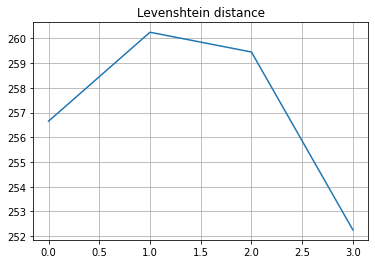

In [108]:
plt.plot(history[:,2])
plt.grid(True)
plt.title('Levenshtein distance')

In [16]:
gc.collect()
torch.cuda.empty_cache()